<a href="https://colab.research.google.com/github/bautista3383/Ventas_Retail/blob/main/Ventas_Retail_Final_con_manejo_de_at%C3%ADpicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Análisis de Ventas, Preprocesamiento y Modelado
Doble objetivo (total_venta, venta_unidades)
"""

# --- 0. Importación de Librerías ---
print("--- 0. Importando librerías ---")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

# Se desactivan advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Se configura el estilo de las gráficas
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
# Se ajusta el formato de números flotantes para una mejor lectura
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("Librerías instaladas-")

--- 0. Importando librerías ---
Librerías instaladas-


In [ ]:
# Instalación de la librería oficial de Kaggle (la -q es para que no muestre tanto texto)
!pip install kaggle -q
# Importación de la utilidad de archivos de Colab
from google.colab import files

# Diálogo para seleccionar el archivo
print('Sube tu archivo kaggle.json:')
files.upload()
# Creación de la carpeta oculta .kaggle donde la librería busca el API token
!mkdir -p ~/.kaggle

# Copia del archivo subido a esa carpeta
!cp kaggle.json ~/.kaggle/

# Asignación de los permisos correctos al archivo
!chmod 600 ~/.kaggle/kaggle.json
# Descarga del dataset usando su "slug": tevecsystems/retail-sales-forecasting
!kaggle datasets download -d tevecsystems/retail-sales-forecasting
# Descompresión del archivo .zip descargado
!unzip retail-sales-forecasting.zip
# Lista de los archivos para confirmar que 'mock_kaggle.csv' está ahí
!ls

Sube tu archivo kaggle.json:


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/tevecsystems/retail-sales-forecasting
License(s): CC-BY-NC-SA-4.0
retail-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  retail-sales-forecasting.zip
replace mock_kaggle.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mock_kaggle.csv         
 1_histograma_inicial_venda.png         8_agg_dia_mes_predicciones_iqr.png
 2_histogramas_post_limpieza_iqr.png    9_agg_semana_predicciones_iqr.png
 3_serie_temporal_total_venta_iqr.png  'kaggle (1).json'
 4_graficas_agregadas_periodo_iqr.png   kaggle.json
 5_matriz_correlacion_general_iqr.png   mock_kaggle.csv
 6_matriz_correlacion_lags.png	        retail-sales-forecasting.zip
 7_ts_predicciones_comparadas_iqr.png   sample_data



--- 1. Carga y EDA Inicial ---
Dataset 'mock_kaggle.csv' cargado exitosamente.

Información inicial del DataFrame (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     937 non-null    object 
 1   venda    937 non-null    int64  
 2   estoque  937 non-null    int64  
 3   preco    937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB

Primeras 5 filas del dataset (df.head()):
         data  venda  estoque  preco
0  2014-01-01      0     4972   1.29
1  2014-01-02     70     4902   1.29
2  2014-01-03     59     4843   1.29
3  2014-01-04     93     4750   1.29
4  2014-01-05     96     4654   1.29

Resumen estadístico inicial (df.describe()):
       venda  estoque  preco
count 937.00   937.00 937.00
mean   90.53  1608.26   1.59
std    80.68  1356.69   0.53
min     0.00     0.00   0.00
25%    33.00   794.00

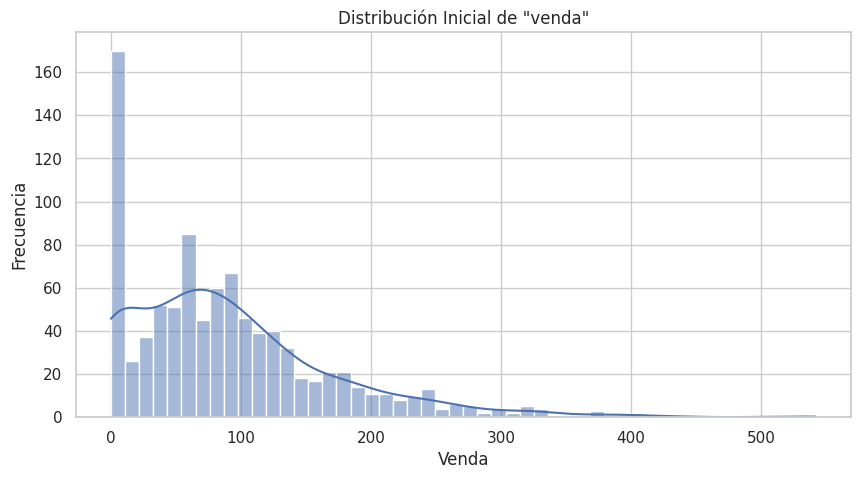

In [ ]:
# --- 1. Carga y EDA Inicial ---
print("\n--- 1. Carga y EDA Inicial ---")
try:
    # Se asume que el archivo 'mock_kaggle.csv' está cargado en Colab
    df = pd.read_csv('mock_kaggle.csv')
    print("Dataset 'mock_kaggle.csv' cargado exitosamente.")
except FileNotFoundError:
    print("Error: No se pudo encontrar el archivo 'mock_kaggle.csv'.")
    exit()

# Se realiza un análisis exploratorio inicial
print("\nInformación inicial del DataFrame (df.info()):")
df.info()
print("\nPrimeras 5 filas del dataset (df.head()):")
print(df.head())
print("\nResumen estadístico inicial (df.describe()):")
print(df.describe())
print("\nValores nulos iniciales (df.isnull().sum()):")
print(df.isnull().sum())

# Visualización inicial de la variable 'venda'
print("\nGenerando histograma inicial de 'venda'...")
plt.figure(figsize=(10, 5))
sns.histplot(df['venda'], kde=True, bins=50)
plt.title('Distribución Inicial de "venda"')
plt.xlabel('Venda')
plt.ylabel('Frecuencia')
plt.savefig('1_histograma_inicial_venda.png')
print("Histograma '1_histograma_inicial_venda.png' guardado.")

In [ ]:
# --- 2. Limpieza, Preprocesamiento y Creación de Variables ---
print("\n--- 2. Limpieza, Preprocesamiento y Creación de Variables ---")

df_clean = df.copy()

# Se renombran las columnas
columnas_nuevas = {
    'data': 'fecha',
    'venda': 'venta_unidades',
    'estoque': 'stock',
    'preco': 'precio'
}
df_clean = df_clean.rename(columns=columnas_nuevas)
print(f"Columnas renombradas a: {list(df_clean.columns)}")

# --- LÓGICA DE PARSEO DE FECHA (Y-M-D inferido) ---
df_clean['fecha'] = pd.to_datetime(df_clean['fecha'], errors='coerce')
null_dates_count = df_clean['fecha'].isnull().sum()
if null_dates_count > 0:
    print(f"ADVERTENCIA: Se eliminaron {null_dates_count} filas con formatos de fecha inválidos.")
    df_clean = df_clean.dropna(subset=['fecha'])
else:
    print("Columna 'fecha' convertida a datetime exitosamente (formato YYYY-MM-DD inferido).")

df_clean = df_clean.sort_values(by='fecha').reset_index(drop=True)

# Se crea la columna 'total_venta' (Esta es la versión 'sucia' u original)
df_clean['total_venta'] = df_clean['venta_unidades'] * df_clean['precio']
print("Columna 'total_venta' (original) creada.")

# --- Se guarda una copia ANTES de ajustar atípicos ---
df_copia_original = df_clean.copy()

# --- Manejo de Atípicos con Rango Intercuartílico (IQR) ---
print("\nManejando valores atípicos (Criterio: Rango Intercuartílico)...")

# --- Se definen solo las columnas 'driver' (base) ---
# total_venta se ELIMINA de esta lista, porque será recalculada.
columnas_driver = ['venta_unidades', 'stock', 'precio']

print("--- Límites Calculados (Superior / Inferior) ---")

# --- El bucle solo itera sobre las columnas 'driver' ---
for col in columnas_driver:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    print(f"  {col:15} | Límite Inferior: {limite_inferior:8.2f} | Límite Superior: {limite_superior:8.2f}")

    # Se aplica el 'clipping' (recorte) solo a las columnas base
    df_clean[col] = np.clip(df_clean[col], limite_inferior, limite_superior)

print("Valores atípicos de 'drivers' (unidades, stock, precio) ajustados.")


# Ahora que 'venta_unidades' y 'precio' están limpios (recortados),
# recalculamos 'total_venta' para que la matemática sea consistente.
print("\nRecalculando 'total_venta' usando valores limpios para mantener coherencia...")
df_clean['total_venta'] = df_clean['venta_unidades'] * df_clean['precio']
print("Columna 'total_venta' (limpia) recalculada.")
# --- FIN DE LA NUEVA LÍNEA ---


# --- Auditoría de Valores Atípicos Ajustados ---
# Esta sección comparará la 'total_venta' recalculada con la original,
print("\n--- Auditoría de Valores Atípicos Ajustados ---")
columnas_a_auditar = ['venta_unidades', 'stock', 'precio', 'total_venta']
mask_cambios = (df_clean[columnas_a_auditar] != df_copia_original[columnas_a_auditar]).any(axis=1)
num_cambios = mask_cambios.sum()
if num_cambios == 0:
    print("RESULTADO: No se modificó ninguna fila.")
else:
    print(f"RESULTADO: Se ajustaron {num_cambios} filas (incluyendo 'total_venta' recalculada).")


# --- Manejo de Valores Nulos (Otras columnas) ---
if df_clean.isnull().sum().any():
    print("\nDetectados valores nulos en OTRAS columnas. Se aplicará 'forward fill' (ffill)...")
    df_clean = df_clean.ffill()
else:
    print("\nNo se encontraron valores nulos en el dataset.")


--- 2. Limpieza, Preprocesamiento y Creación de Variables ---
Columnas renombradas a: ['fecha', 'venta_unidades', 'stock', 'precio']
Columna 'fecha' convertida a datetime exitosamente (formato YYYY-MM-DD inferido).
Columna 'total_venta' (original) creada.

Manejando valores atípicos (Criterio: Rango Intercuartílico)...
--- Límites Calculados (Superior / Inferior) ---
  venta_unidades  | Límite Inferior:  -108.00 | Límite Superior:   268.00
  stock           | Límite Inferior:  -961.00 | Límite Superior:  3719.00
  precio          | Límite Inferior:     0.39 | Límite Superior:     2.79
Valores atípicos de 'drivers' (unidades, stock, precio) ajustados.

Recalculando 'total_venta' usando valores limpios para mantener coherencia...
Columna 'total_venta' (limpia) recalculada.

--- Auditoría de Valores Atípicos Ajustados ---
RESULTADO: Se ajustaron 147 filas (incluyendo 'total_venta' recalculada).

No se encontraron valores nulos en el dataset.


In [ ]:
# --- 3. Ingeniería de Variables de Tiempo ---
print("\n--- 3. Ingeniería de Variables de Tiempo ---")

df_clean['dia_semana'] = df_clean['fecha'].dt.dayofweek + 1
df_clean['num_semana_ano'] = df_clean['fecha'].dt.isocalendar().week.astype(int)
df_clean['mes'] = df_clean['fecha'].dt.month
df_clean['ano'] = df_clean['fecha'].dt.year

# Se crean nombres para los gráficos
nombres_meses = {1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'}
nombres_dias = {1: 'Lun', 2: 'Mar', 3: 'Mié', 4: 'Jue', 5: 'Vie', 6: 'Sáb', 7: 'Dom'}
df_clean['nombre_mes'] = df_clean['mes'].map(nombres_meses)
df_clean['nombre_dia'] = df_clean['dia_semana'].map(nombres_dias)
meses_ordenados = list(nombres_meses.values())
dias_ordenados = list(nombres_dias.values())

print("Variables de tiempo ('dia_semana', 'num_semana_ano', 'mes', 'ano', etc.) creadas.")


--- 3. Ingeniería de Variables de Tiempo ---
Variables de tiempo ('dia_semana', 'num_semana_ano', 'mes', 'ano', etc.) creadas.



--- 4. EDA Post-Limpieza y Visualización ---

Resumen estadístico post-limpieza (df_clean.describe()):
       venta_unidades   stock  precio  total_venta  dia_semana  \
count          937.00  937.00  937.00       937.00      937.00   
mean            87.99 1487.71    1.59       144.08        4.01   
std             72.58 1024.26    0.51       132.65        2.00   
min              0.00    0.00    0.39         0.00        1.00   
25%             33.00  794.00    1.29        52.32        2.00   
50%             76.00 1348.00    1.39       111.86        4.00   
75%            127.00 1964.00    1.89       207.10        6.00   
max            268.00 3719.00    2.79       694.12        7.00   

       num_semana_ano    mes     ano  
count          937.00 937.00  937.00  
mean            24.38   5.98 2014.84  
std             14.71   3.35    0.77  
min              1.00   1.00 2014.00  
25%             12.00   3.00 2014.00  
50%             23.00   6.00 2015.00  
75%             36.00   9.00

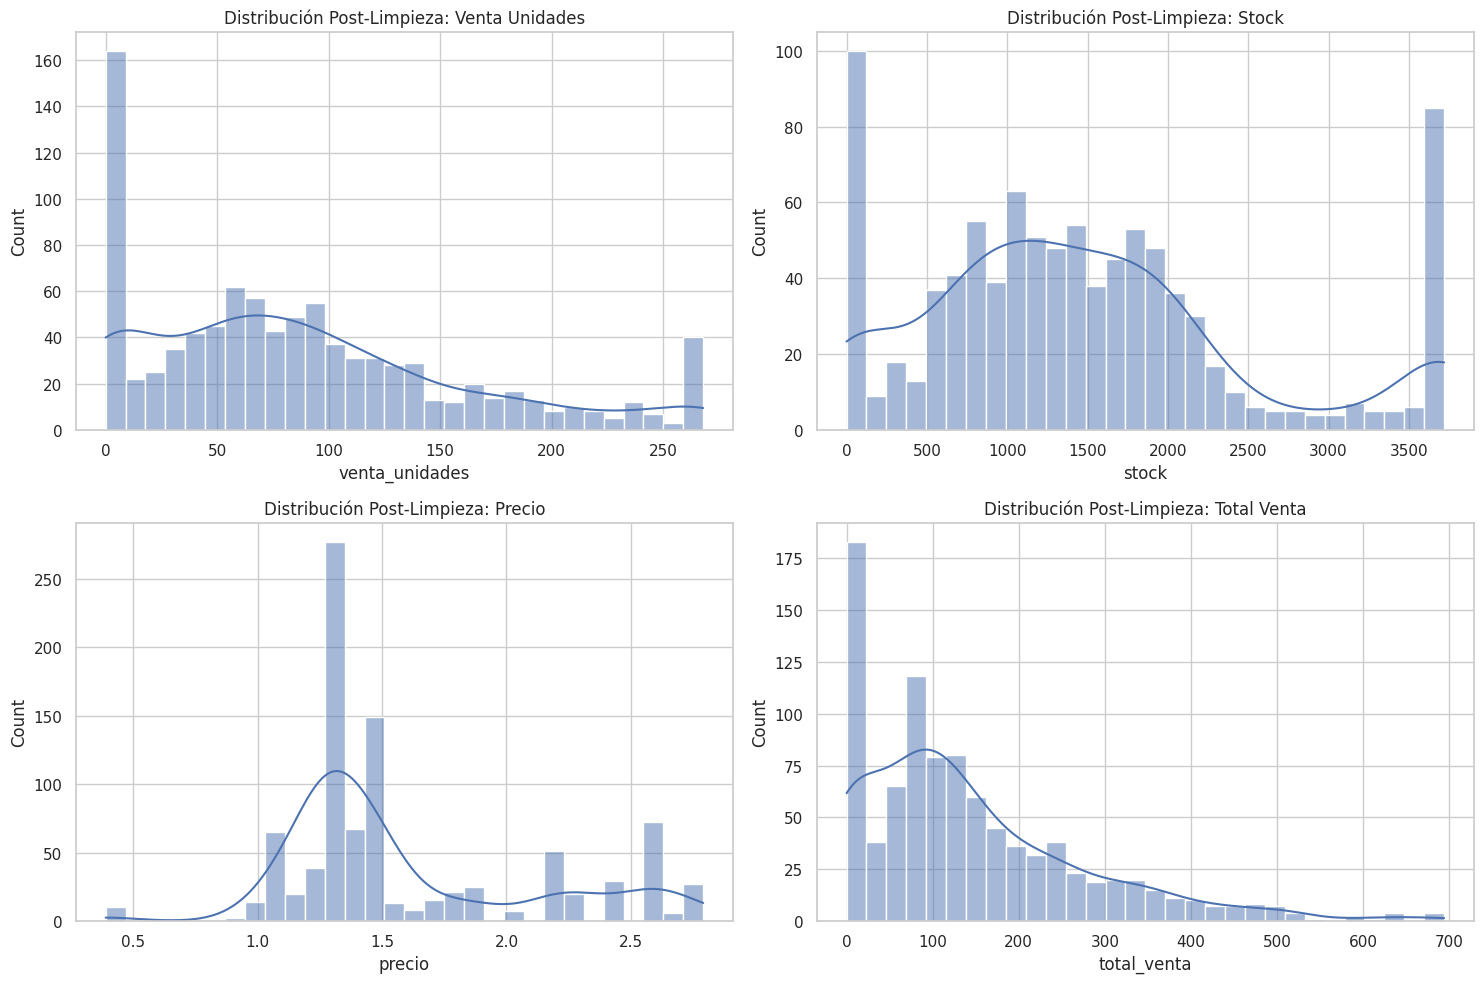

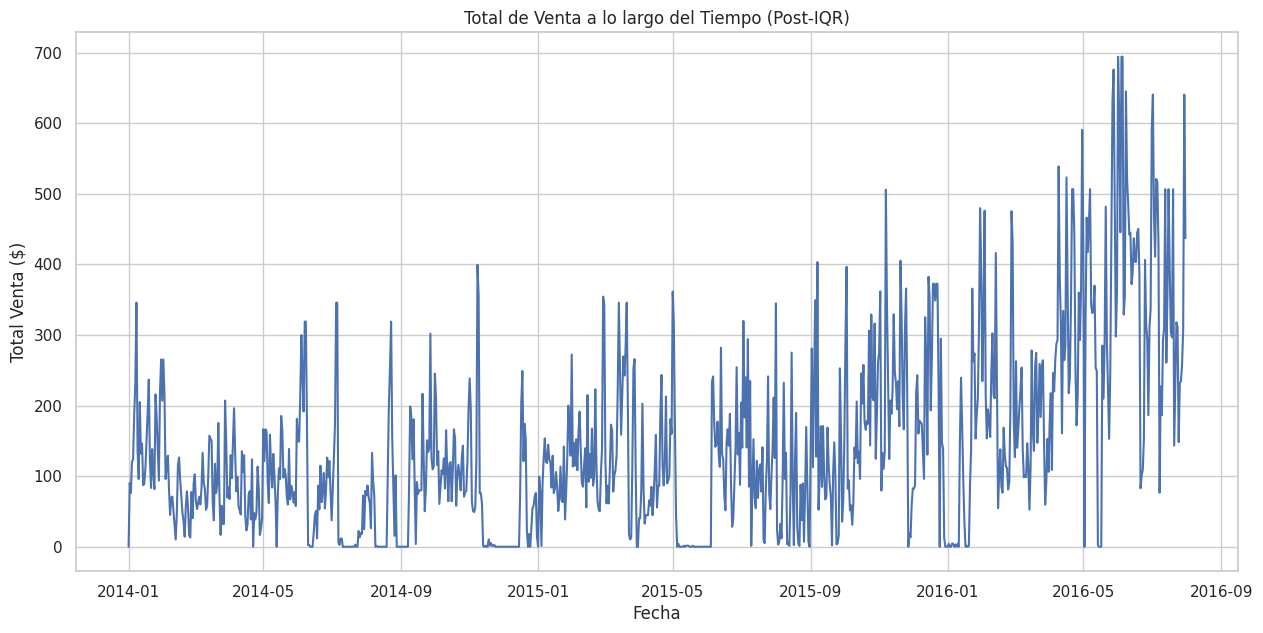

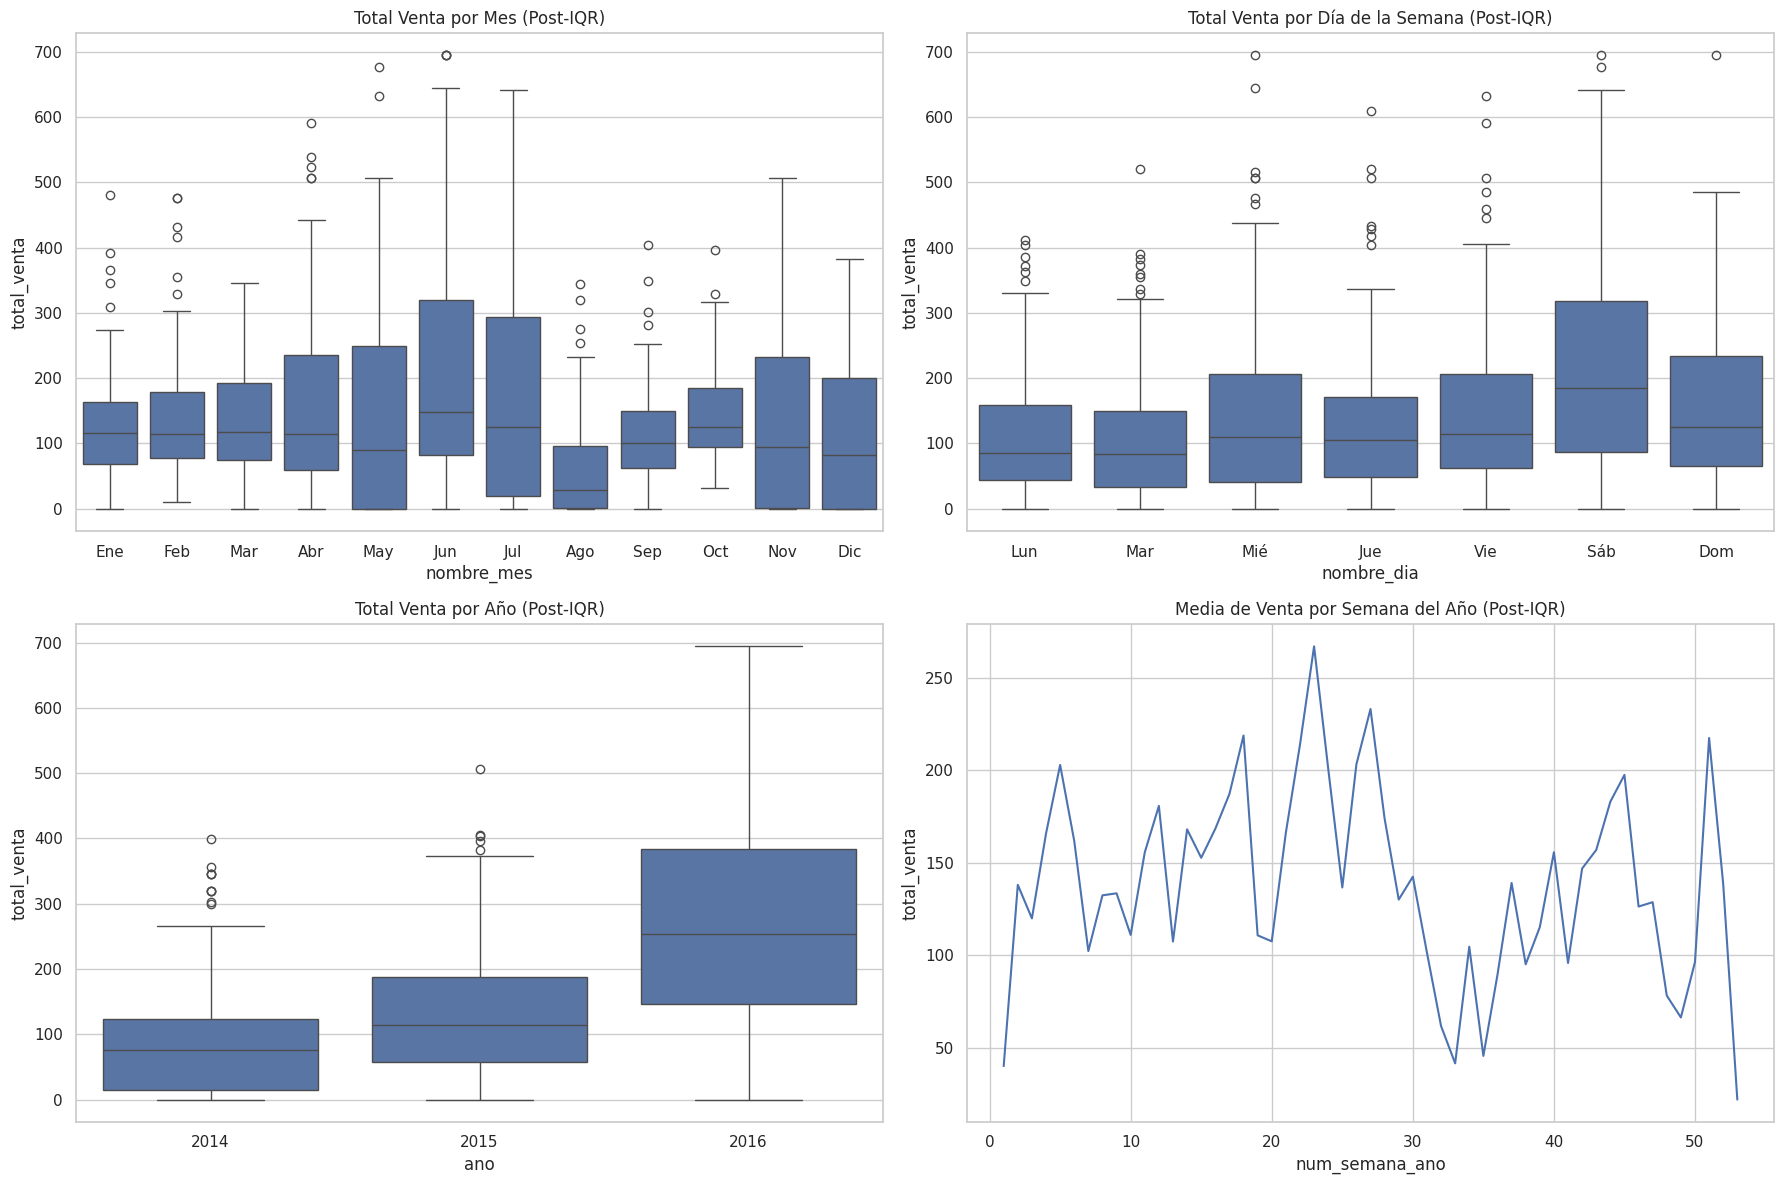

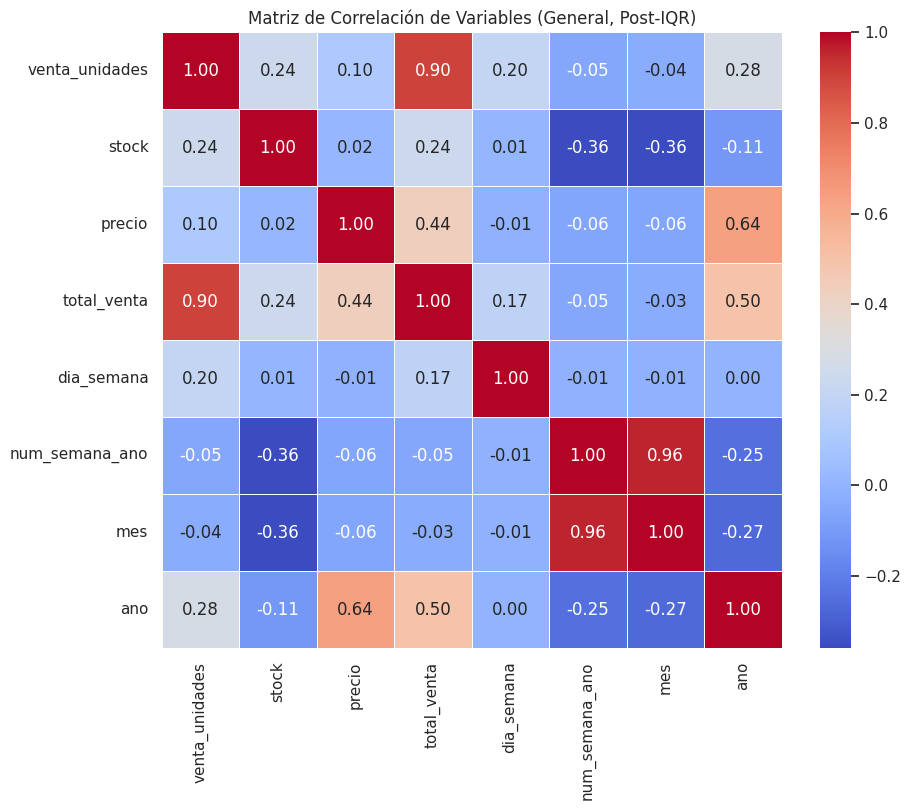

In [ ]:
# --- 4. EDA Post-Limpieza y Visualización ---
print("\n--- 4. EDA Post-Limpieza y Visualización ---")
print("\nResumen estadístico post-limpieza (df_clean.describe()):")
print(df_clean.describe(include=[np.number]))

# Gráficas de distribución post-limpieza
print("Generando gráficas de distribución post-limpieza...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_clean['venta_unidades'], kde=True, ax=axes[0, 0], bins=30).set_title('Distribución Post-Limpieza: Venta Unidades')
sns.histplot(df_clean['stock'], kde=True, ax=axes[0, 1], bins=30).set_title('Distribución Post-Limpieza: Stock')
sns.histplot(df_clean['precio'], kde=True, ax=axes[1, 0], bins=30).set_title('Distribución Post-Limpieza: Precio')
sns.histplot(df_clean['total_venta'], kde=True, ax=axes[1, 1], bins=30).set_title('Distribución Post-Limpieza: Total Venta')
plt.tight_layout()
plt.savefig('2_histogramas_post_limpieza_iqr.png')
print("Gráficas '2_histogramas_post_limpieza_iqr.png' guardadas.")

# Visualización por Fecha (Serie Temporal)
print("Generando gráfica de 'total_venta' a lo largo del tiempo...")
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_clean, x='fecha', y='total_venta')
plt.title('Total de Venta a lo largo del Tiempo (Post-IQR)')
plt.xlabel('Fecha')
plt.ylabel('Total Venta ($)')
plt.savefig('3_serie_temporal_total_venta_iqr.png')
print("Gráfica '3_serie_temporal_total_venta_iqr.png' guardada.")

# Visualización por Períodos Agregados
print("Generando gráficas de ventas agregadas por período...")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
sns.boxplot(data=df_clean, x='nombre_mes', y='total_venta', ax=axes[0, 0], order=meses_ordenados).set_title('Total Venta por Mes (Post-IQR)')
sns.boxplot(data=df_clean, x='nombre_dia', y='total_venta', ax=axes[0, 1], order=dias_ordenados).set_title('Total Venta por Día de la Semana (Post-IQR)')
sns.boxplot(data=df_clean, x='ano', y='total_venta', ax=axes[1, 0]).set_title('Total Venta por Año (Post-IQR)')
semanas_agg = df_clean.groupby('num_semana_ano')['total_venta'].mean().reset_index()
sns.lineplot(data=semanas_agg, x='num_semana_ano', y='total_venta', ax=axes[1, 1]).set_title('Media de Venta por Semana del Año (Post-IQR)')
plt.tight_layout()
plt.savefig('4_graficas_agregadas_periodo_iqr.png')
print("Gráficas '4_graficas_agregadas_periodo_iqr.png' guardadas.")

# Matriz de Correlación General
print("\nGenerando matriz de correlación (General)...")
columnas_corr = ['venta_unidades', 'stock', 'precio', 'total_venta', 'dia_semana', 'num_semana_ano', 'mes', 'ano']
matriz_corr = df_clean[columnas_corr].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación de Variables (General, Post-IQR)')
plt.savefig('5_matriz_correlacion_general_iqr.png')
print("Gráfica '5_matriz_correlacion_general_iqr.png' guardada.")

In [ ]:
# --- 5. Ingeniería de Variables (Lags) para Modelado ---
print("\n--- 5. Ingeniería de Variables (Lags) para Modelado ---")
# Se usarán los lags que coincidían con el resultado anterior de 7 filas eliminadas
print("Generando lags (1, 7 días) y medias móviles (7 días)...")

# Lags simples
df_clean['total_venta_lag_1'] = df_clean['total_venta'].shift(1)
df_clean['total_venta_lag_7'] = df_clean['total_venta'].shift(7)
df_clean['venta_unidades_lag_1'] = df_clean['venta_unidades'].shift(1)
df_clean['venta_unidades_lag_7'] = df_clean['venta_unidades'].shift(7)

# Medias móviles de 7 días
df_clean['total_venta_roll_7'] = df_clean['total_venta'].shift(1).rolling(window=7).mean()
df_clean['venta_unidades_roll_7'] = df_clean['venta_unidades'].shift(1).rolling(window=7).mean()
df_clean['precio_roll_7'] = df_clean['precio'].shift(1).rolling(window=7).mean()
df_clean['stock_roll_7'] = df_clean['stock'].shift(1).rolling(window=7).mean()

# Se eliminan los valores NaN creados por los lags (shift(7) y rolling(7) crean 7 NaNs)
df_model = df_clean.dropna()
print(f"Dataset listo para modelado. Se eliminaron {len(df_clean) - len(df_model)} filas con NaNs (por lags).")
print(f"Tamaño del dataset para modelado: {df_model.shape}")


--- 5. Ingeniería de Variables (Lags) para Modelado ---
Generando lags (1, 7 días) y medias móviles (7 días)...
Dataset listo para modelado. Se eliminaron 7 filas con NaNs (por lags).
Tamaño del dataset para modelado: (930, 19)



Generando matriz de correlación (Lags y Targets)...
Gráfica '6_matriz_correlacion_lags.png' guardada.


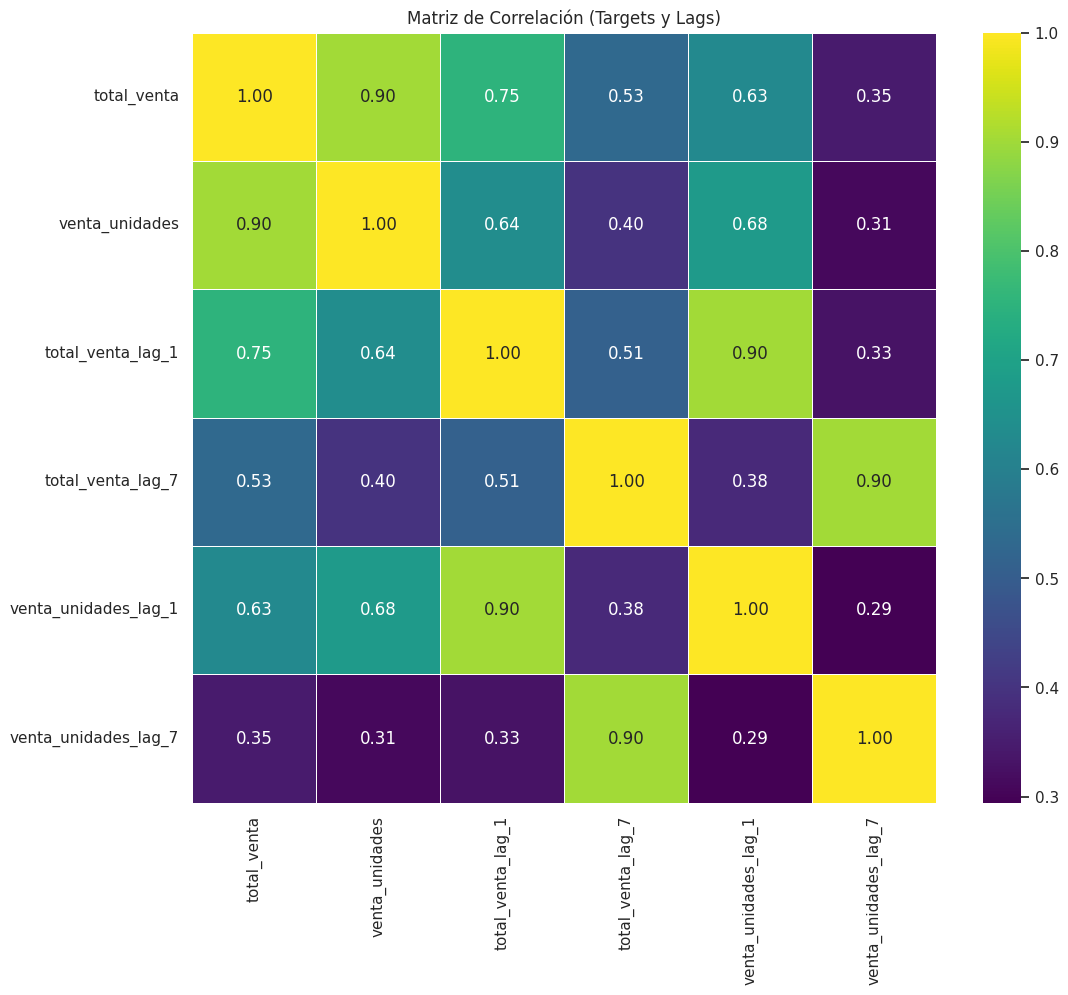

In [ ]:
# --- 5.1 Matriz de Correlación (Lags) ---
print("\nGenerando matriz de correlación (Lags y Targets)...")

# Se seleccionan solo los targets y las variables de lag
columnas_corr_lags = [
    'total_venta', 'venta_unidades',
    'total_venta_lag_1', 'total_venta_lag_7', 'total_venta_roll_30', 'total_venta_roll_365',
    'venta_unidades_lag_1', 'venta_unidades_lag_7', 'venta_unidades_roll_30', 'venta_unidades_roll_365'
]
# Se asegura que solo se usen columnas presentes en df_model (por si alguna falla)
columnas_corr_lags_presentes = [col for col in columnas_corr_lags if col in df_model.columns]
matriz_corr_lags = df_model[columnas_corr_lags_presentes].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(matriz_corr_lags, annot=True, fmt='.2f', cmap='viridis', linewidths=0.5)
plt.title('Matriz de Correlación (Targets y Lags)')
plt.savefig('6_matriz_correlacion_lags.png')
print("Gráfica '6_matriz_correlacion_lags.png' guardada.")

In [ ]:
# --- 6. Preprocesamiento y Entrenamiento (Doble Modelo) ---
print("\n--- 6. Preprocesamiento y Entrenamiento (Doble Modelo) ---")

# --- 6.1 Preprocesamiento ---
print("Preparando datos para el modelo...")

# Se definen las variables predictoras (X)
features = [
    'dia_semana', 'num_semana_ano', 'mes', 'ano',
    'precio', 'stock',
    'precio_roll_7', 'stock_roll_7',
    'total_venta_lag_1', 'total_venta_lag_7', 'total_venta_roll_7',
    'venta_unidades_lag_1', 'venta_unidades_lag_7', 'venta_unidades_roll_7'
]
# Se definen los dos targets (y)
target_tv = 'total_venta'
target_vu = 'venta_unidades'

features_presentes = [col for col in features if col in df_model.columns]
X = df_model[features_presentes]
y_tv = df_model[target_tv]
y_vu = df_model[target_vu]

print(f"Se usarán {len(features_presentes)} variables predictoras.")
print(f"Target 1: {target_tv}")
print(f"Target 2: {target_vu}")

# División de datos (train/test)
X_train, X_test, y_tv_train, y_tv_test, y_vu_train, y_vu_test = train_test_split(
    X, y_tv, y_vu, test_size=0.2, shuffle=False
)

print(f"Tamaño de datos de entrenamiento: {X_train.shape[0]} filas")
print(f"Tamaño de datos de prueba: {X_test.shape[0]} filas")

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Datos de entrenamiento y prueba escalados (StandardScaler).")


--- 6. Preprocesamiento y Entrenamiento (Doble Modelo) ---
Preparando datos para el modelo...
Se usarán 14 variables predictoras.
Target 1: total_venta
Target 2: venta_unidades
Tamaño de datos de entrenamiento: 744 filas
Tamaño de datos de prueba: 186 filas
Datos de entrenamiento y prueba escalados (StandardScaler).


In [ ]:
# --- 6.2 Entrenamiento ---

# Modelo 1: total_venta
print("\nEntrenando Modelo 1 (para total_venta)...")
model_tv = LinearRegression()
model_tv.fit(X_train_scaled, y_tv_train)
print("Modelo 1 (total_venta) entrenado.")

# Modelo 2: venta_unidades
print("Entrenando Modelo 2 (para venta_unidades)...")
model_vu = LinearRegression()
model_vu.fit(X_train_scaled, y_vu_train)
print("Modelo 2 (venta_unidades) entrenado.")


Entrenando Modelo 1 (para total_venta)...
Modelo 1 (total_venta) entrenado.
Entrenando Modelo 2 (para venta_unidades)...
Modelo 2 (venta_unidades) entrenado.


In [ ]:
# --- 6.3 Evaluación ---
print("\nEvaluando modelos...")

# Predicciones de ambos modelos
y_pred_tv = model_tv.predict(X_test_scaled)
y_pred_vu = model_vu.predict(X_test_scaled)

# Métricas para total_venta
print("\n--- Métricas de Desempeño (Modelo total_venta) ---")
mae_tv = mean_absolute_error(y_tv_test, y_pred_tv)
mse_tv = mean_squared_error(y_tv_test, y_pred_tv)
rmse_tv = np.sqrt(mse_tv) # Corrección para versiones antiguas de sklearn
r2_tv = r2_score(y_tv_test, y_pred_tv)
print(f"MAE (total_venta):   {mae_tv:.2f}")
print(f"RMSE (total_venta):  {rmse_tv:.2f}")
print(f"R² (total_venta):    {r2_tv:.4f}")

# Métricas para venta_unidades
print("\n--- Métricas de Desempeño (Modelo venta_unidades) ---")
mae_vu = mean_absolute_error(y_vu_test, y_pred_vu)
mse_vu = mean_squared_error(y_vu_test, y_pred_vu)
rmse_vu = np.sqrt(mse_vu) # Corrección para versiones antiguas de sklearn
r2_vu = r2_score(y_vu_test, y_pred_vu)
print(f"MAE (venta_unidades):   {mae_vu:.2f}")
print(f"RMSE (venta_unidades):  {rmse_vu:.2f}")
print(f"R² (venta_unidades):    {r2_vu:.4f}")


Evaluando modelos...

--- Métricas de Desempeño (Modelo total_venta) ---
MAE (total_venta):   86.63
RMSE (total_venta):  113.38
R² (total_venta):    0.4862

--- Métricas de Desempeño (Modelo venta_unidades) ---
MAE (venta_unidades):   42.46
RMSE (venta_unidades):  52.52
R² (venta_unidades):    0.5172


Visualización de la 'Pérdida' (Gráficos de Residuos)
Gráfica '10_graficos_residuos.png' guardada.


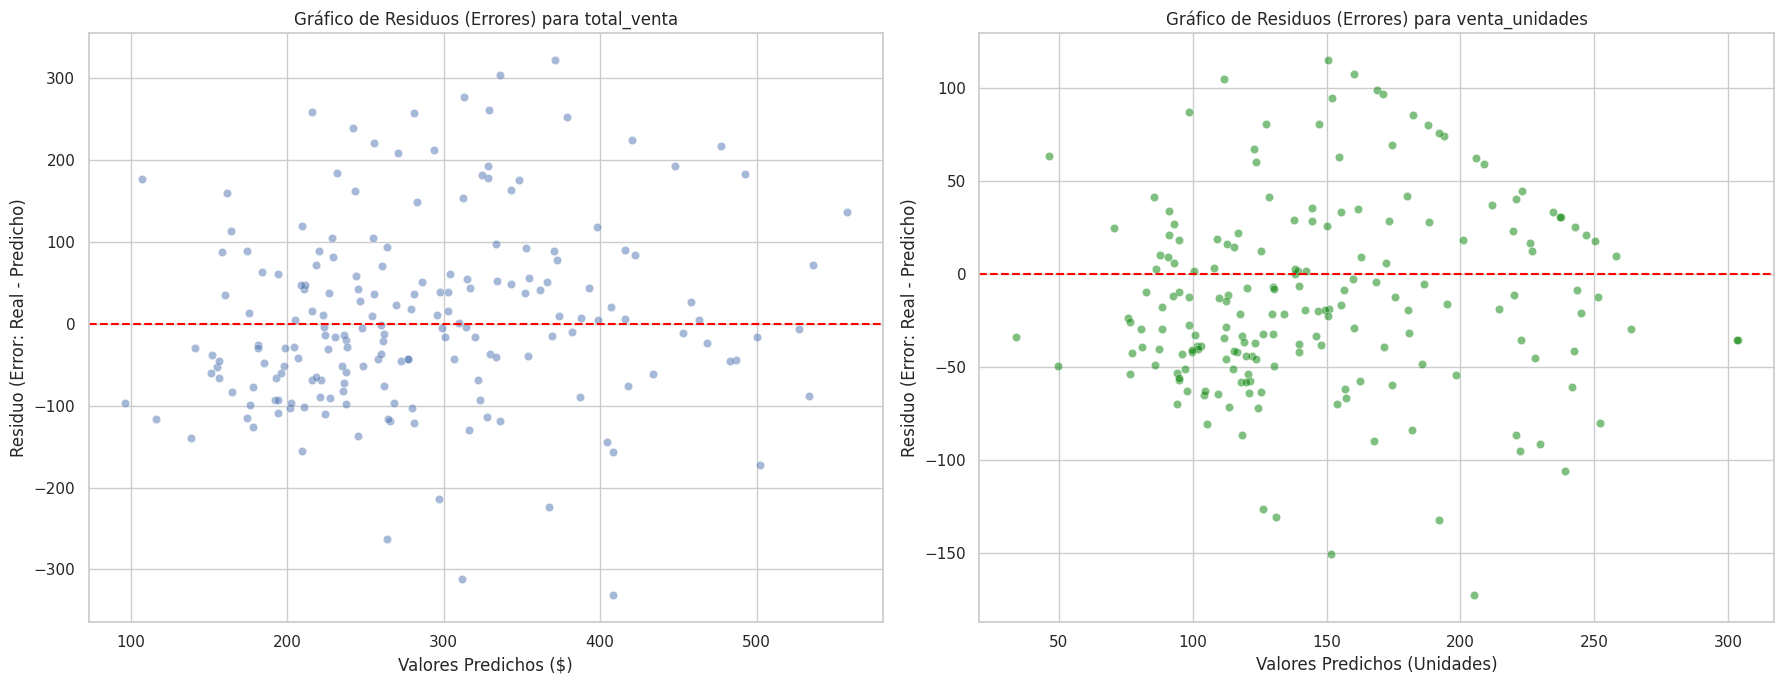

In [ ]:
# Visualización de la "Pérdida" (Gráficos de Residuos) ---


print("Visualización de la 'Pérdida' (Gráficos de Residuos)")

# Se calculan los residuos (errores) para ambos modelos
# Residuo = Valor Real - Valor Predicho
residuals_tv = y_tv_test - y_pred_tv
residuals_vu = y_vu_test - y_pred_vu

# Se crea un DataFrame para facilitar el gráfico con Seaborn
df_residuos = pd.DataFrame({
    'Prediccion_TV': y_pred_tv,
    'Residuo_TV': residuals_tv,
    'Prediccion_VU': y_pred_vu,
    'Residuo_VU': residuals_vu
})

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico de Residuos para total_venta
sns.scatterplot(data=df_residuos, x='Prediccion_TV', y='Residuo_TV', alpha=0.5, ax=axes[0])
axes[0].axhline(y=0, color='red', linestyle='--') # Línea de error cero
axes[0].set_title('Gráfico de Residuos (Errores) para total_venta')
axes[0].set_xlabel('Valores Predichos ($)')
axes[0].set_ylabel('Residuo (Error: Real - Predicho)')

# Gráfico de Residuos para venta_unidades
sns.scatterplot(data=df_residuos, x='Prediccion_VU', y='Residuo_VU', alpha=0.5, ax=axes[1], color='green')
axes[1].axhline(y=0, color='red', linestyle='--') # Línea de error cero
axes[1].set_title('Gráfico de Residuos (Errores) para venta_unidades')
axes[1].set_xlabel('Valores Predichos (Unidades)')
axes[1].set_ylabel('Residuo (Error: Real - Predicho)')

plt.tight_layout()
plt.savefig('10_graficos_residuos.png')
print("Gráfica '10_graficos_residuos.png' guardada.")


--- 7. Visualización de Resultados del Modelo ---
Generando gráficos de serie temporal (Predicción vs Real)...
Gráfica '7_ts_predicciones_comparadas_iqr.png' guardada.
Generando gráficos agregados (Por Día de Semana y Mes)...
Gráfica '8_agg_dia_mes_predicciones_iqr.png' guardada.
Generando gráficos agregados (Por Semana del Año)...
Gráfica '9_agg_semana_predicciones_iqr.png' guardada.


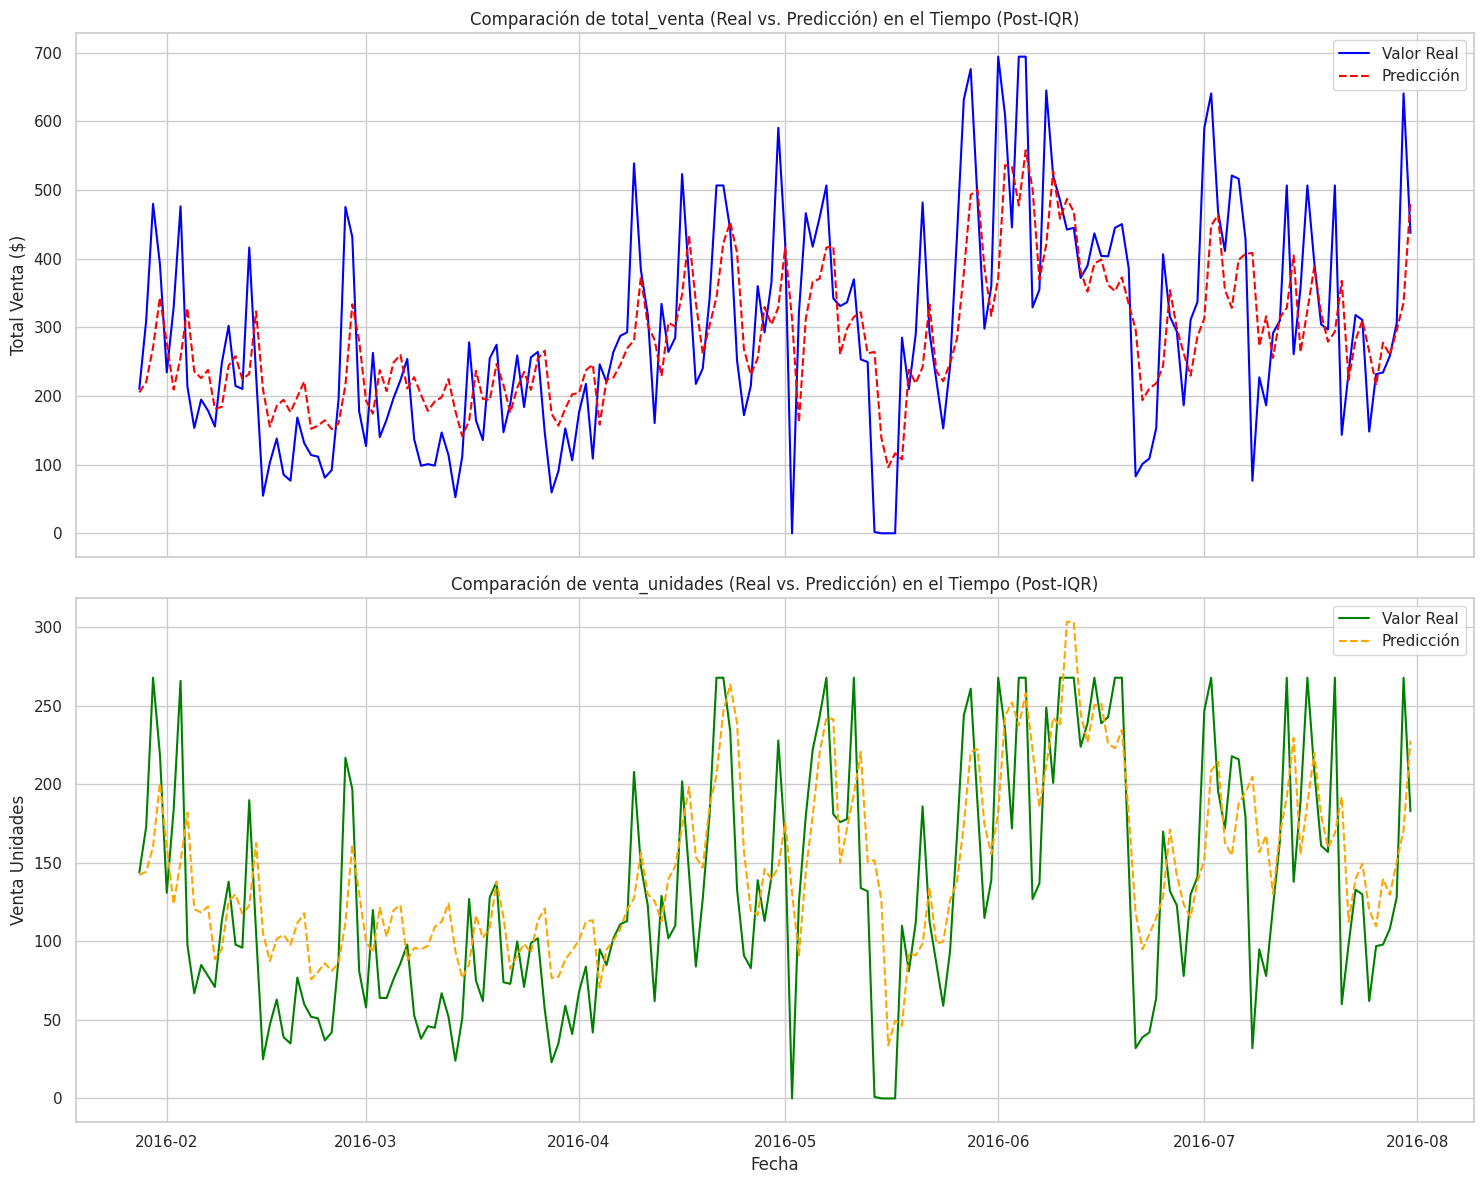

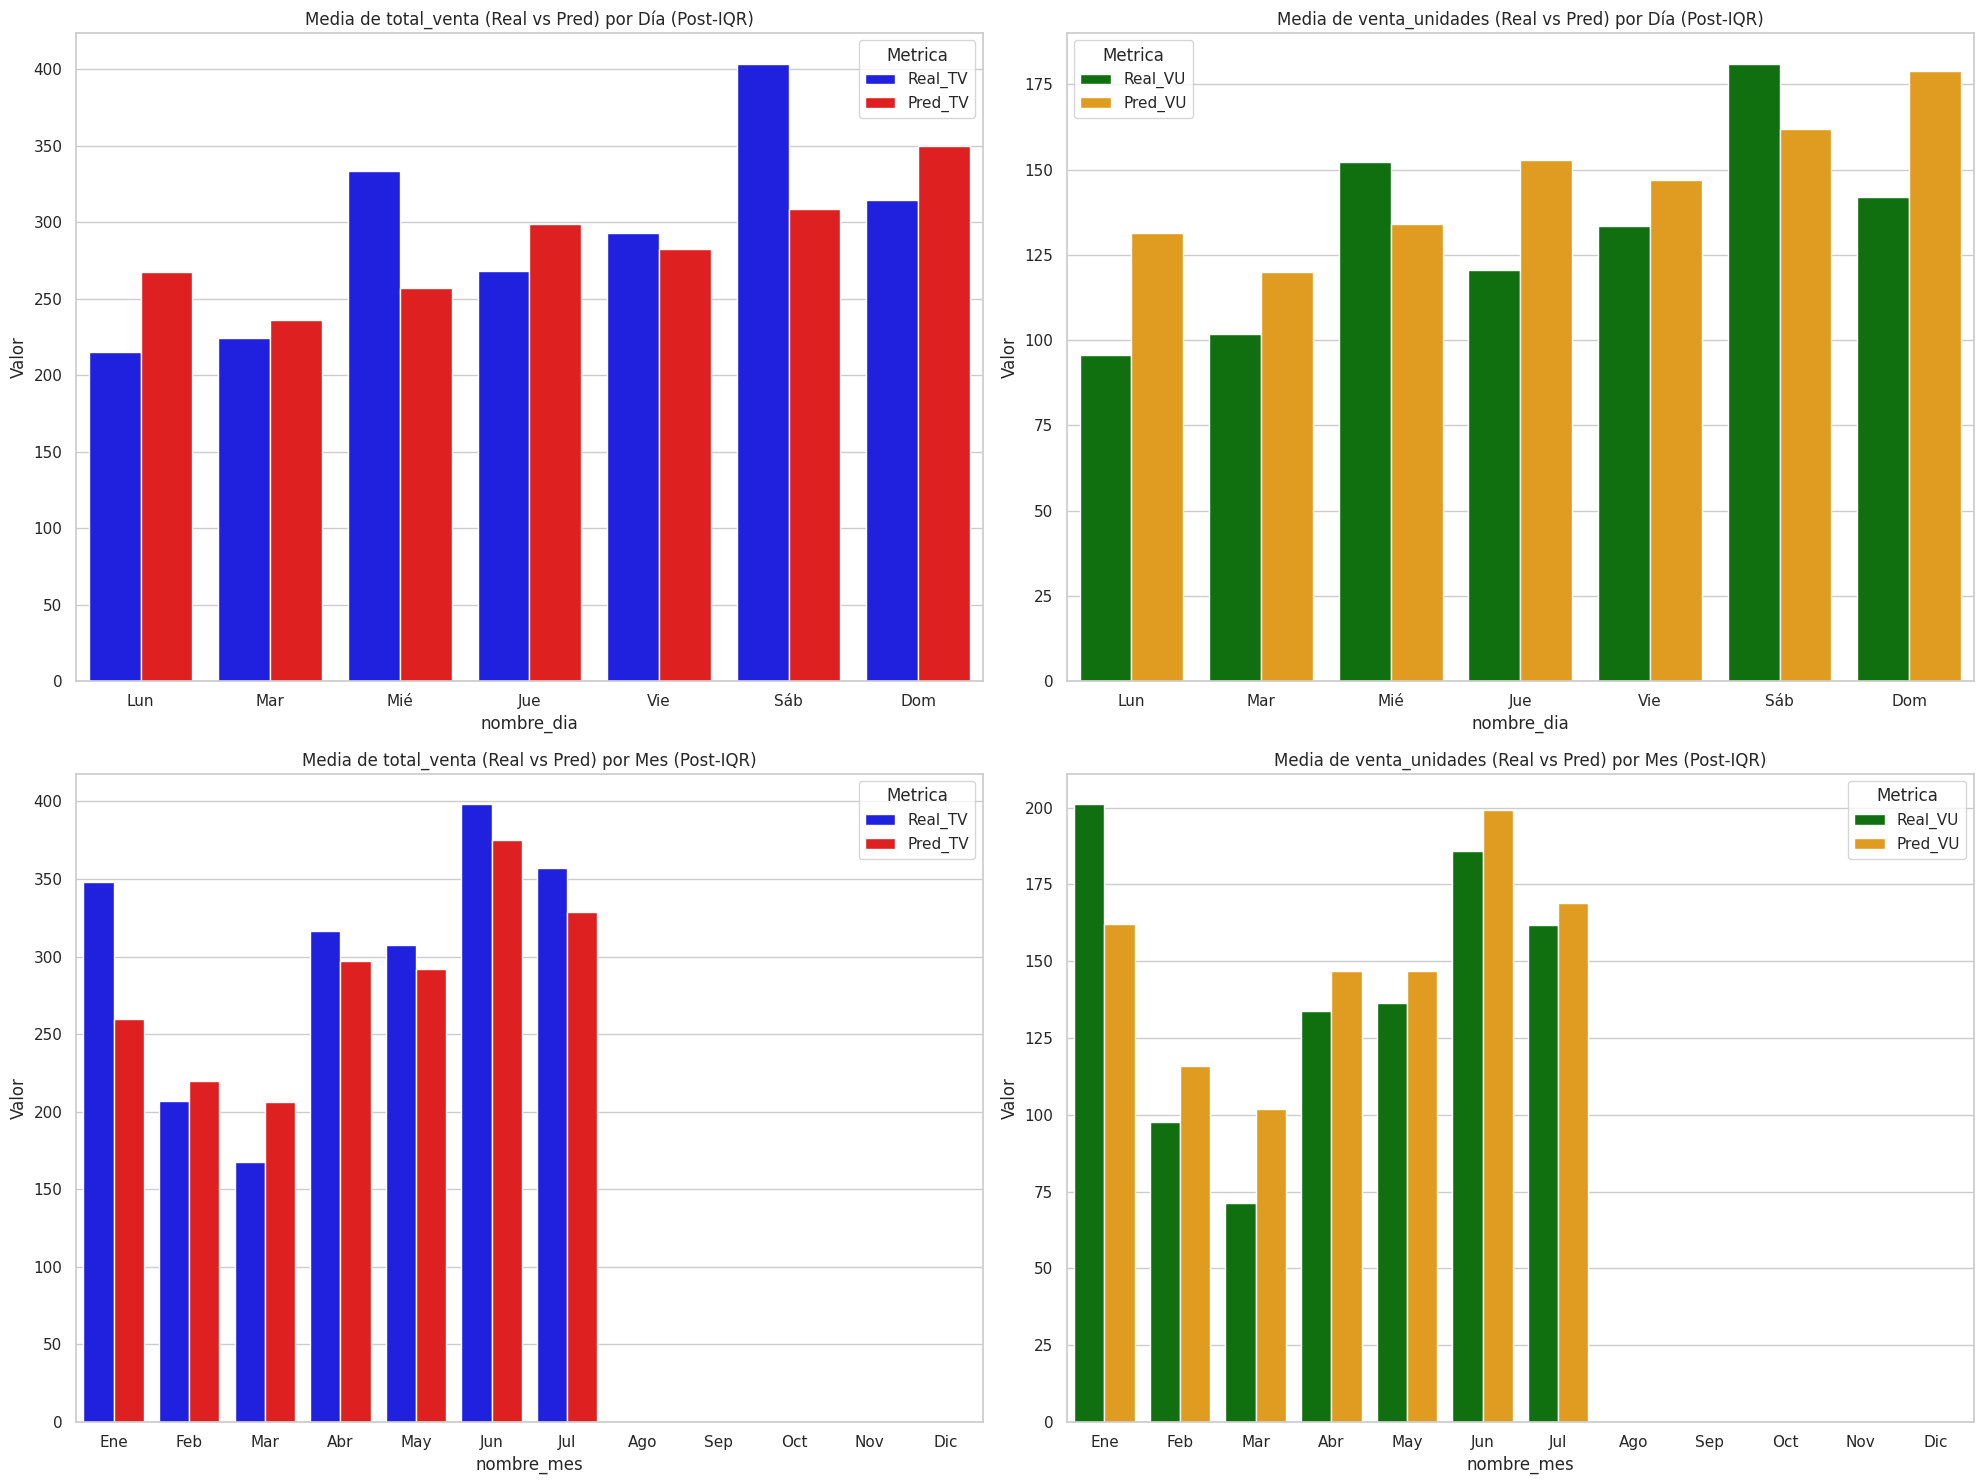

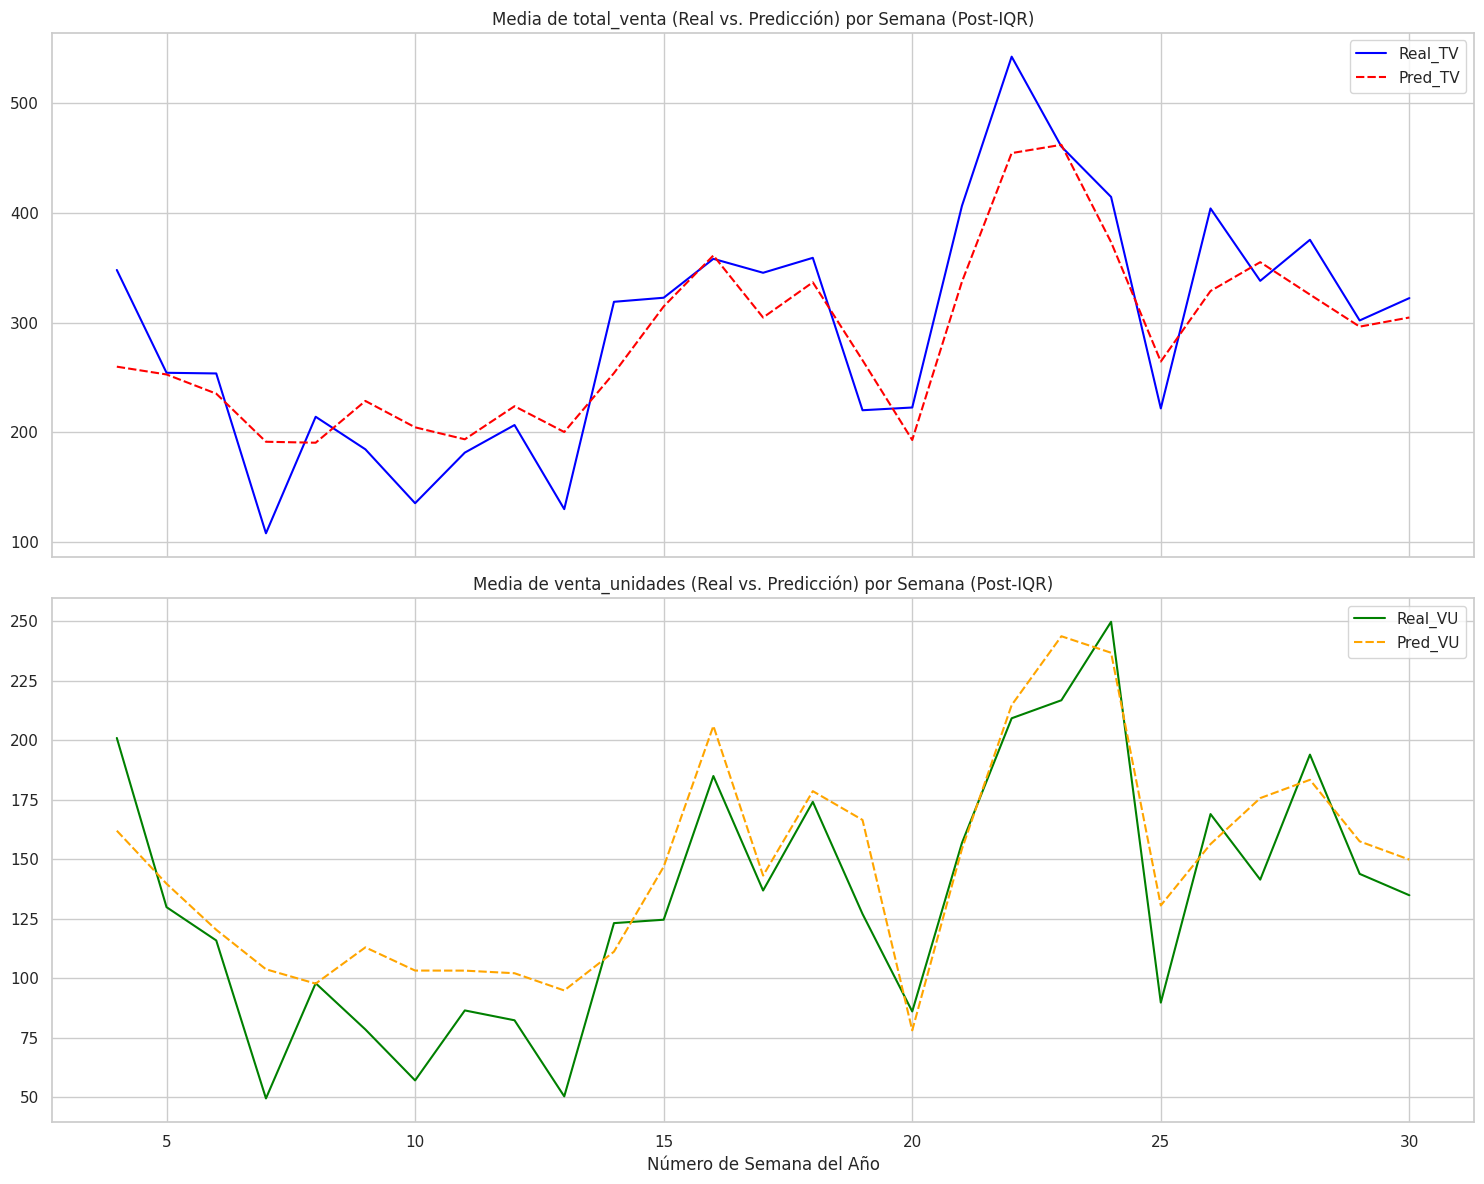

In [ ]:
# --- 7. Visualización de Resultados del Modelo ---
print("\n--- 7. Visualización de Resultados del Modelo ---")

# Se crea un DataFrame central con todos los resultados
results_df = df_model.loc[X_test.index, ['fecha', 'nombre_dia', 'nombre_mes', 'num_semana_ano']].copy()
results_df['Real_TV'] = y_tv_test
results_df['Pred_TV'] = y_pred_tv
results_df['Real_VU'] = y_vu_test
results_df['Pred_VU'] = y_pred_vu

# --- Gráficos por Fecha (Series Temporales) ---
print("Generando gráficos de serie temporal (Predicción vs Real)...")
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
sns.lineplot(data=results_df, x='fecha', y='Real_TV', label='Valor Real', color='blue', ax=axes[0])
sns.lineplot(data=results_df, x='fecha', y='Pred_TV', label='Predicción', color='red', linestyle='--', ax=axes[0])
axes[0].set_title('Comparación de total_venta (Real vs. Predicción) en el Tiempo (Post-IQR)')
axes[0].set_ylabel('Total Venta ($)')
sns.lineplot(data=results_df, x='fecha', y='Real_VU', label='Valor Real', color='green', ax=axes[1])
sns.lineplot(data=results_df, x='fecha', y='Pred_VU', label='Predicción', color='orange', linestyle='--', ax=axes[1])
axes[1].set_title('Comparación de venta_unidades (Real vs. Predicción) en el Tiempo (Post-IQR)')
axes[1].set_ylabel('Venta Unidades')
axes[1].set_xlabel('Fecha')
plt.tight_layout()
plt.savefig('7_ts_predicciones_comparadas_iqr.png')
print("Gráfica '7_ts_predicciones_comparadas_iqr.png' guardada.")

# --- Gráficos Agregados (Día y Mes) ---
print("Generando gráficos agregados (Por Día de Semana y Mes)...")
agg_dia = results_df.groupby('nombre_dia')[['Real_TV', 'Pred_TV', 'Real_VU', 'Pred_VU']].mean().reindex(dias_ordenados)
agg_mes = results_df.groupby('nombre_mes')[['Real_TV', 'Pred_TV', 'Real_VU', 'Pred_VU']].mean().reindex(meses_ordenados)
agg_dia_melt = agg_dia.reset_index().melt('nombre_dia', var_name='Metrica', value_name='Valor')
agg_mes_melt = agg_mes.reset_index().melt('nombre_mes', var_name='Metrica', value_name='Valor')

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.barplot(data=agg_dia_melt[agg_dia_melt['Metrica'].isin(['Real_TV', 'Pred_TV'])], x='nombre_dia', y='Valor', hue='Metrica', ax=axes[0, 0], palette={'Real_TV': 'blue', 'Pred_TV': 'red'})
axes[0, 0].set_title('Media de total_venta (Real vs Pred) por Día (Post-IQR)')
sns.barplot(data=agg_dia_melt[agg_dia_melt['Metrica'].isin(['Real_VU', 'Pred_VU'])], x='nombre_dia', y='Valor', hue='Metrica', ax=axes[0, 1], palette={'Real_VU': 'green', 'Pred_VU': 'orange'})
axes[0, 1].set_title('Media de venta_unidades (Real vs Pred) por Día (Post-IQR)')
sns.barplot(data=agg_mes_melt[agg_mes_melt['Metrica'].isin(['Real_TV', 'Pred_TV'])], x='nombre_mes', y='Valor', hue='Metrica', ax=axes[1, 0], palette={'Real_TV': 'blue', 'Pred_TV': 'red'})
axes[1, 0].set_title('Media de total_venta (Real vs Pred) por Mes (Post-IQR)')
sns.barplot(data=agg_mes_melt[agg_mes_melt['Metrica'].isin(['Real_VU', 'Pred_VU'])], x='nombre_mes', y='Valor', hue='Metrica', ax=axes[1, 1], palette={'Real_VU': 'green', 'Pred_VU': 'orange'})
axes[1, 1].set_title('Media de venta_unidades (Real vs Pred) por Mes (Post-IQR)')
plt.tight_layout()
plt.savefig('8_agg_dia_mes_predicciones_iqr.png')
print("Gráfica '8_agg_dia_mes_predicciones_iqr.png' guardada.")

# --- Gráficos Agregados (Semana) ---
print("Generando gráficos agregados (Por Semana del Año)...")
agg_sem = results_df.groupby('num_semana_ano')[['Real_TV', 'Pred_TV', 'Real_VU', 'Pred_VU']].mean()
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
sns.lineplot(data=agg_sem[['Real_TV', 'Pred_TV']], ax=axes[0], palette={'Real_TV': 'blue', 'Pred_TV': 'red'}, legend=True)
axes[0].set_title('Media de total_venta (Real vs. Predicción) por Semana (Post-IQR)')
sns.lineplot(data=agg_sem[['Real_VU', 'Pred_VU']], ax=axes[1], palette={'Real_VU': 'green', 'Pred_VU': 'orange'}, legend=True)
axes[1].set_title('Media de venta_unidades (Real vs. Predicción) por Semana (Post-IQR)')
axes[1].set_xlabel('Número de Semana del Año')
plt.tight_layout()
plt.savefig('9_agg_semana_predicciones_iqr.png')
print("Gráfica '9_agg_semana_predicciones_iqr.png' guardada.")

In [ ]:
# --- 8. Resultados de Predicciones para Casos de Prueba Aleatorios ---
print("\n--- 8. Casos de Prueba Aleatorios (5 por Período) ---")

# --- Predicciones para total_venta ---
print("\n--- Casos de Prueba: total_venta ---")

# Por Fecha (diario)
print("\nPor Fecha (5 casos diarios aleatorios del Test Set):")
print(results_df.sample(5, random_state=1)[['fecha', 'Real_TV', 'Pred_TV']].to_string(index=False))

# Por Día de la Semana (agregado)
print("\nPor Día de la Semana (5 casos aleatorios, media del Test Set):")
print(agg_dia.sample(5, random_state=1)[['Real_TV', 'Pred_TV']])

# Por Semana del Año (agregado)
print("\nPor Semana del Año (5 casos aleatorios, media del Test Set):")
print(agg_sem.sample(5, random_state=1)[['Real_TV', 'Pred_TV']])

# Por Mes (agregado)
print("\nPor Mes (5 casos aleatorios, media del Test Set):")
print(agg_mes.sample(5, random_state=1)[['Real_TV', 'Pred_TV']])


# --- Predicciones para venta_unidades ---
print("\n\n--- Casos de Prueba: venta_unidades ---")

# Por Fecha (diario)
print("\nPor Fecha (5 casos diarios aleatorios del Test Set):")
print(results_df.sample(5, random_state=2)[['fecha', 'Real_VU', 'Pred_VU']].to_string(index=False))

# Por Día de la Semana (agregado)
print("\nPor Día de la Semana (5 casos aleatorios, media del Test Set):")
print(agg_dia.sample(5, random_state=2)[['Real_VU', 'Pred_VU']])

# Por Semana del Año (agregado)
print("\nPor Semana del Año (5 casos aleatorios, media del Test Set):")
print(agg_sem.sample(5, random_state=2)[['Real_VU', 'Pred_VU']])

# Por Mes (agregado)
print("\nPor Mes (5 casos aleatorios, media del Test Set):")
print(agg_mes.sample(5, random_state=2)[['Real_VU', 'Pred_VU']])


print("\n--- Análisis Completado Exitosamente ---")


--- 8. Casos de Prueba Aleatorios (5 por Período) ---

--- Casos de Prueba: total_venta ---

Por Fecha (5 casos diarios aleatorios del Test Set):
     fecha  Real_TV  Pred_TV
2016-02-13   416.10   232.17
2016-07-26   231.83   215.75
2016-04-03   108.78   245.60
2016-03-08   137.27   227.28
2016-07-13   506.52   328.28

Por Día de la Semana (5 casos aleatorios, media del Test Set):
            Real_TV  Pred_TV
nombre_dia                  
Dom          314.17   349.48
Mié          333.25   257.17
Mar          224.10   235.74
Lun          215.02   267.26
Vie          292.91   282.50

Por Semana del Año (5 casos aleatorios, media del Test Set):
                Real_TV  Pred_TV
num_semana_ano                  
21               406.26   337.21
18               358.96   336.68
22               542.05   454.30
7                108.25   191.56
27               338.01   355.00

Por Mes (5 casos aleatorios, media del Test Set):
            Real_TV  Pred_TV
nombre_mes                  
Mar       